In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path|
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

In [9]:
class setup:
    input_power = 0.035 # mW
    input_db = -14.43 # dBmW
    nm_in_del = 0.1 # nm/del

def t_coeff(n):
    '''
    Returns t-test coefficient
    n -- number of points
    '''
    assert n > 0, 'n must be positive'
    __students = [12.7062, 4.3027, 3.1824, 2.7764, 2.5706, 2.4469, 2.3646, 2.3060, 2.2622]
    if n < len(__students):
        return __students[n-1]
    else:
        return 2

## 2. Spotaneous amplified emission

In [10]:
sr = 28

spontan = [
    [0.96,  0,  pd.read_csv('data/spontaneous0.csv', skiprows=sr).iloc[:, 0]],
    [1.93,  3,  pd.read_csv('data/spontaneous1.csv', skiprows=sr).iloc[:, 0]],
    [3.93,  6,  pd.read_csv('data/spontaneous2.csv', skiprows=sr).iloc[:, 0]],
    [7.96,  9,  pd.read_csv('data/spontaneous3.csv', skiprows=sr).iloc[:, 0]],
    [15.98, 12, pd.read_csv('data/spontaneous4.csv', skiprows=sr).iloc[:, 0]]
]

print(len(spontan[0][2].index.values))
print(len(spontan[0][2].values))

851
851


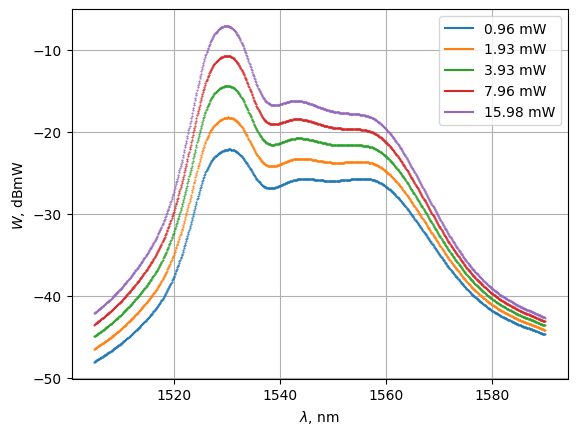

In [11]:
for series in spontan:
    mipt.plot(series[2].index.values, series[2].values, func=None, marker_size=1, label=str(series[0]) + ' mW')

plt.grid()
plt.legend()

plt.ylabel(r"$W$, dBmW")
plt.xlabel(r"$\lambda$, nm")

plt.savefig("gen/spontaneous.pdf")


## 3. EDFA amplifier coefficient

In [12]:
sr = 28

induced = [
    [0.94, 0, pd.read_csv('data/ind0.csv', skiprows=sr).iloc[:, 0]],
    [1.55, 2, pd.read_csv('data/ind1.csv', skiprows=sr).iloc[:, 0]],
    [2.53, 4, pd.read_csv('data/ind2.csv', skiprows=sr).iloc[:, 0]],
    [3.95, 6, pd.read_csv('data/ind3.csv', skiprows=sr).iloc[:, 0]],
    [6.37, 8, pd.read_csv('data/ind4.csv', skiprows=sr).iloc[:, 0]],
    [9.95, 10, pd.read_csv('data/ind5.csv', skiprows=sr).iloc[:, 0]],
    [15.95, 12, pd.read_csv('data/ind6.csv', skiprows=sr).iloc[:, 0]],
    [25.16, 14, pd.read_csv('data/ind7.csv', skiprows=sr).iloc[:, 0]],
    [39.98, 16, pd.read_csv('data/ind8.csv', skiprows=sr).iloc[:, 0]],
]

input = [
    pd.read_csv('data/input_before.csv', skiprows=sr).iloc[:, 0],
    pd.read_csv('data/input_after.csv', skiprows=sr).iloc[:, 0]
]

input

[1505.0   -62.542
 1505.1   -61.831
 1505.2   -61.581
 1505.3   -61.636
 1505.4   -61.996
            ...  
 1589.6   -68.673
 1589.7   -70.462
 1589.8   -66.898
 1589.9   -68.718
 1590.0   -71.384
 Name: [TRACE DATA], Length: 851, dtype: float64,
 1505.0   -61.445
 1505.1   -61.199
 1505.2   -61.470
 1505.3   -61.183
 1505.4   -61.391
            ...  
 1589.6   -61.127
 1589.7   -62.319
 1589.8   -61.809
 1589.9   -62.837
 1590.0   -62.561
 Name: [TRACE DATA], Length: 851, dtype: float64]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


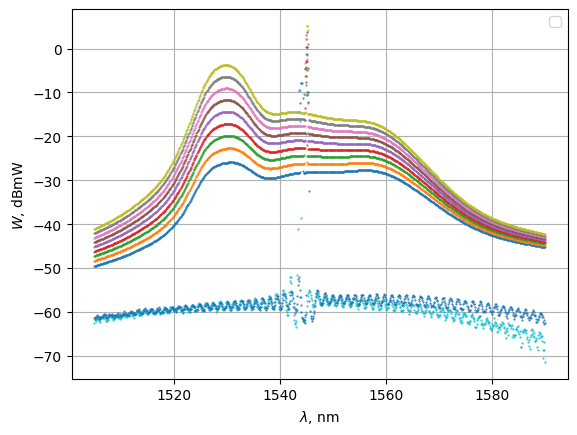

In [13]:
from scipy.interpolate import CubicSpline

i = 0

for series in induced:
    x = series[2].index.values
    y = series[2].values

    poly = CubicSpline(x, y)
    lin = np.linspace(min(x), max(x), 1000)
    # plt.plot(lin, poly(lin), color='C' + str(i))
    mipt.plot(x, y, color='C' + str(i), func=None, marker_size=1)
    i += 1

for series in input:
    x = series.index.values
    y = series.values

    poly = CubicSpline(x, y)
    lin = np.linspace(min(x), max(x), 1000)
    # plt.plot(lin, poly(lin), color='C' + str(i))
    mipt.plot(x, y, color='C' + str(i), func=None, marker_size=1)
    i += 1

plt.grid()
plt.legend()

plt.ylabel(r"$W$, dBmW")
plt.xlabel(r"$\lambda$, nm")

plt.savefig("gen/induced.pdf")


start/end, width: 388/394, 0.60 nm
start/end, width: 396/402, 0.60 nm
start/end, width: 395/401, 0.60 nm
start/end, width: 398/403, 0.50 nm
start/end, width: 398/403, 0.50 nm
start/end, width: 398/404, 0.60 nm
start/end, width: 397/403, 0.60 nm
start/end, width: 399/404, 0.50 nm
start/end, width: 399/404, 0.50 nm


start/end, width: 383/391, 0.80 nm
start/end, width: 399/406, 0.70 nm
osnr = (20.013222222222222 +- 0.14893680820907274)
NF = (16.019796963195457 +- 0.17152065762211396)


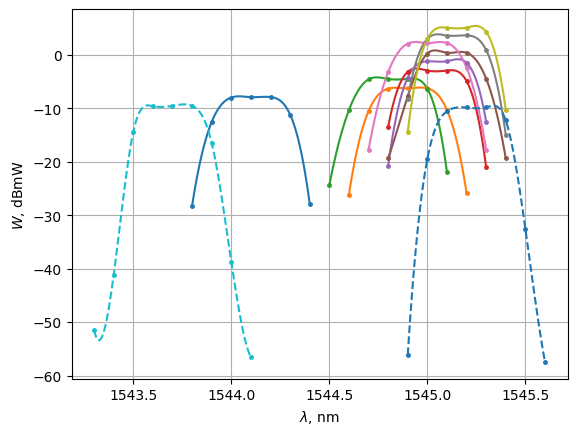

In [14]:
def find_peak(y, slope):

    start = 0
    end = 0

    entered_peak = False
    left_peak = False
    for indx in range(0, len(x)):
        k = (y[indx + 1] - y[indx]) / (x[indx + 1] - x[indx])

        if (k > slope and not entered_peak): # entered peak, first point with high slope
            start = indx
            entered_peak = True
        if (k < -slope and entered_peak): # leaving plateau
            left_peak = True
        if (k > -slope and left_peak):
            end = indx
            return start, end

    assert 0, 'Peak was not found'


start_arr = []
end_arr = []
center_arr = []
width_arr = []
osnr_arr = []

i = 0
for series in induced:
    x = series[2].index.values
    y = series[2].values

    start, end = find_peak(y, 100)
 
    center = int((start + end) / 2)
    width = (end - start) * setup.nm_in_del

    start_arr.append(start)
    end_arr.append(end)
    center_arr.append(center)
    width_arr.append(width)
    osnr_arr.append(y[center] - y[end + 1])

    print('start/end, width: {}/{}, {:.2f} nm'.format(start, end, width))
    # plt.axvline(x=x[start], color="C" + str(i), ls=':')
    # plt.axvline(x=x[end], color="C" + str(i), ls=':')

    mipt.plot(x[start:end+1], y[start:end+1], func=CubicSpline, marker_size=5, color="C" + str(i))
    i += 1

print("\n")
for series in input:
    x = series.index.values
    y = series.values

    start, end = find_peak(y, 100)
    print('start/end, width: {}/{}, {:.2f} nm'.format(start, end, (end - start) * setup.nm_in_del))
    # plt.axvline(x=x[start], color="C" + str(i), ls=':')
    # plt.axvline(x=x[end], color="C" + str(i), ls=':')

    mipt.plot(x[start:end+1], y[start:end+1], func=CubicSpline, marker_size=5, color="C" + str(i), linestyle='dashed')
    i += 1

plt.grid()
# plt.legend()

plt.ylabel(r"$W$, dBmW")
plt.xlabel(r"$\lambda$, nm")

plt.savefig("gen/induced_enlarged.pdf")

osnr = np.mean(osnr_arr)
osnr_err = (np.mean(((osnr_arr - osnr)**2)))**0.5
print("osnr = ({} +- {})".format(osnr, osnr_err))


width = np.mean(width_arr)
width_err = (np.mean(((width_arr - width)**2)))**0.5

quant_noise = -10 * np.log(9e16 * 6.63e-34 / (1545e-9)**3 * width * 1e-9 * 1000) / np.log(10)
quant_noise_err = -10 / width * width_err / np.log(10)

NF = quant_noise + setup.input_db - osnr
NF_err = NF * ((quant_noise_err/quant_noise)**2 + (osnr_err/osnr)**2)**0.5
print("NF = ({} +- {})".format(NF, NF_err))

diff: 4
add: 387, orig: 388
diff: 12
add: 387, orig: 388
diff: 11
add: 387, orig: 388
diff: 13
add: 387, orig: 388
diff: 13
add: 387, orig: 388
diff: 14
add: 387, orig: 388
diff: 13
add: 387, orig: 388
diff: 14
add: 387, orig: 388
diff: 14
add: 387, orig: 388


[35.102999999999994,
 37.224000000000004,
 39.83,
 42.596000000000004,
 45.439,
 48.120999999999995,
 50.747,
 53.448,
 56.113]

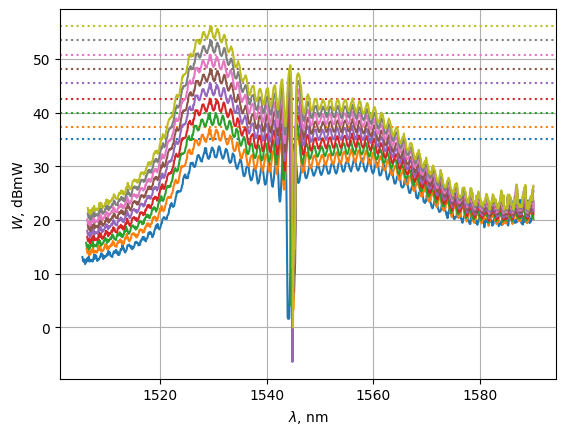

In [15]:
from scipy.interpolate import CubicSpline

output = []

addend = input[0].values
start, end = find_peak(addend, 200)
addend_center = int((start + end) / 2)

for i in range(0, len(induced)):
    series = induced[i]
    x = series[2].index.values
    y = series[2].values
    # p = plt.plot(x, y, label=str(series[0]) + ' mW')

    # print(y)
    diff = center_arr[i] - addend_center
    print('diff: {}'.format(diff))

    # variate(x, y, addend, diff)
    add_shifted = addend[:-diff]
    y = y[diff:]
    x = x[diff:]
    print('add: {}, orig: {}'.format(np.argmax(add_shifted), np.argmax(y)))
    y = y - add_shifted

    # poly = CubicSpline(x, y)
    # lin = np.linspace(min(x), max(x), 1000)
    p = plt.plot(x, y, label=str(series[0]) + ' mW')
    plt.axhline(y=max(y), c=p[-1].get_color(), ls=':')
    output.append(max(y))
    # mipt.plot(series[2].index.values, series[2].values, func=None, marker_size=1, label=str(series[0]) + ' mW')


# for series in input:
#     x = series.index.values
#     y = series.values
#     poly = CubicSpline(x, y)
    # lin = np.linspace(min(x), max(x), 1000)
    # p = plt.plot(lin, poly(lin), label='input')
    # plt.axhline(y=max(y), c=p[-1].get_color(), ls='-.')


plt.grid()
# plt.legend()

plt.ylabel(r"$W$, dBmW")
plt.xlabel(r"$\lambda$, nm")

plt.savefig("gen/diff.pdf")
output


## 4. Output on input and pumping current

In [16]:
data = mipt.read_excel('data/data.xlsx', usecols=['A', 'C'], header=(0)).dropna(how='all').drop_duplicates().reset_index(drop=True)

xls = {

    "mA" : "I",
    "dBm (cor)" : "P"
}

data = mipt.map_excel(data, xls)
data


,I,P
0,25.0,-59.00
1,50.0,-49.00
2,70.0,-7.70
3,90.0,3.45
4,100.0,5.31
5,120.0,7.65
6,140.0,9.16
7,160.0,10.23
8,180.0,11.07
9,200.0,11.77


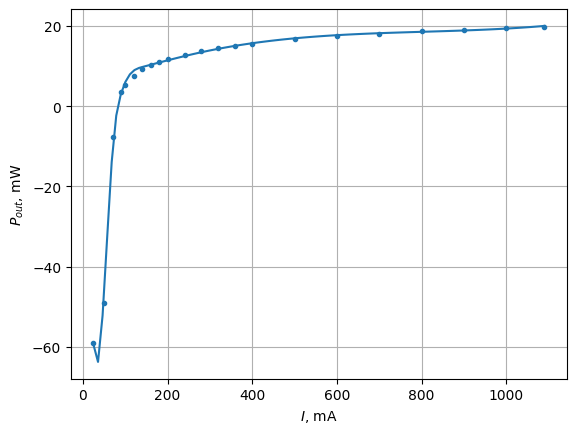

In [17]:
mipt.plot(data["I"], data["P"], func=UnivariateSpline)
# plt.plot(data["I"], data["P"])
plt.grid()
# plt.legend()

plt.ylabel(r"$P_{out}$, mW")
plt.xlabel(r"$I$, mA")

plt.savefig("gen/PI.pdf")



In [18]:
data = mipt.read_excel('data/data.xlsx', usecols=['D', 'E', 'F', 'G', 'H', 'I'], header=(0, 1)).dropna(how='all')
data

xls = {
    "I = 100 mA" : "100",
    "I = 110 mA" : "110",
    "I = 90 mA" : "90",

    "input, mW" : "in",
    "output, mW" : "out"
}

data = mipt.map_excel(data, xls)
data

100          110            90      
       in   out     in    out     in   out
0   0.034  3.42  0.035   5.27  0.034  2.37
1   0.040  5.26  0.040   7.08  0.035  2.65
2   0.050  6.50  0.045   8.05  0.040  3.60
3   0.060  7.25  0.050   8.70  0.045  4.06
4   0.080  8.10  0.060   9.70  0.050  4.45
5   0.100  8.53  0.070  10.25  0.054  4.80
6   0.120  8.93  0.080  10.64  0.060  5.00
7   0.140  9.14  0.090  11.00  0.070  5.38
8   0.160  9.32  0.100  11.34  0.080  5.60
9   0.180  9.45  0.107  11.40  0.090  5.80
10  0.200  9.58    NaN    NaN  0.100  5.97
11  0.230  9.75    NaN    NaN  0.120  6.20
12  0.259  9.85    NaN    NaN  0.150  6.37
13    NaN   NaN    NaN    NaN  0.170  6.50
14    NaN   NaN    NaN    NaN  0.190  6.60
15    NaN   NaN    NaN    NaN  0.220  6.83
16    NaN   NaN    NaN    NaN  0.254  6.95

/home/futherus/.local/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/futherus/.local/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/futherus/.local/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/futherus/.local/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


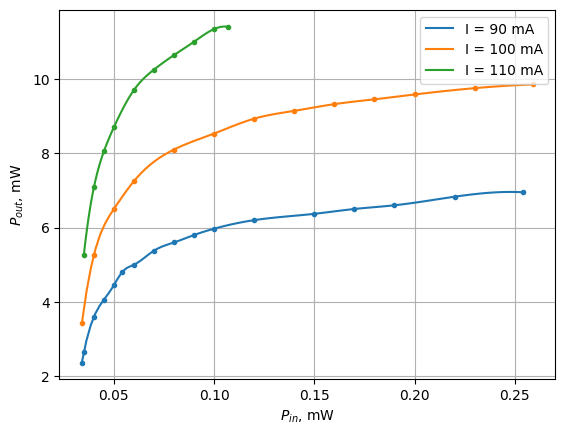

In [19]:


mipt.plot(data["90"]["in"], data["90"]["out"], func=CubicSpline, label = "I = 90 mA")
mipt.plot(data["100"]["in"], data["100"]["out"], func=CubicSpline, label = "I = 100 mA")
mipt.plot(data["110"]["in"], data["110"]["out"], func=CubicSpline, label = "I = 110 mA")

plt.grid()
plt.legend()

plt.ylabel(r"$P_{out}$, mW")
plt.xlabel(r"$P_{in}$, mW")

plt.savefig("gen/fixed.pdf")

